In [2]:
import torch
from torch import nn
from torchsummary import summary

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(ConvBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_filters)

        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_filters)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x - self.bn2(x)
        x - self.relu(x)

        return x

* EncoderBlock, DecoderBlock 구성

In [4]:
class EncoderBlock(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(EncoderBlock, self).__init__()
        
        self.convBlk = ConvBlock(in_filters, out_filters)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.convBlk(x)
        p = self.pool(x)
        return x, p

In [26]:
class DecoderBlock(nn.Module):
    def __init__(self, concat_filters, in_filters, out_filters):
        super(DecoderBlock, self).__init__()
        
        self.transposeConv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size=2, stride=2)
        '''
        Skip Connection 되는 Block들이 많기 때문에 이를 모두 concat_filters라 하고,
        Up-Sampling이 되는 Block을 out_filters로 받아서 Conv Block에 넘긴다.
        '''
        self.convBlk = ConvBlock(concat_filters+out_filters, out_filters)

    def forward(self, x, skip):
        x = self.transposeConv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.convBlk(x)

        return x

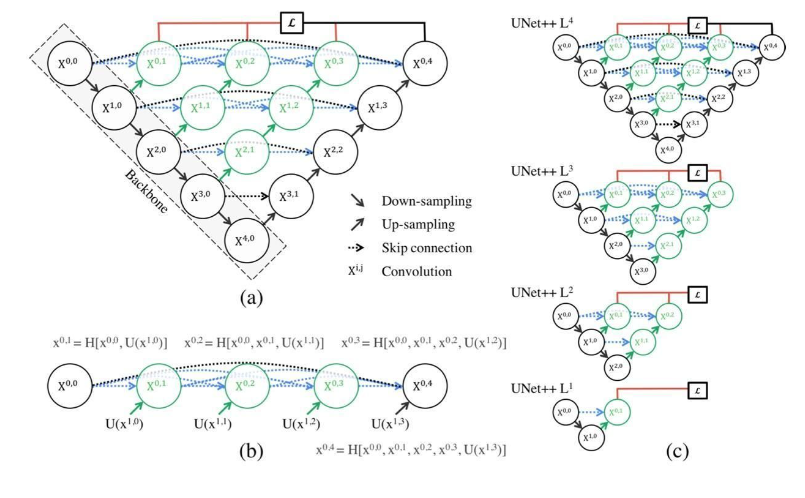

In [27]:
class Nested_UNet_L1(nn.Module):
    def __init__(self, channels, deep_supervision=True):
        super(Nested_UNet_L1, self).__init__()

        self.channels = channels
        self.deep_supervision = deep_supervision

        self.x_0_0 = EncoderBlock(channels, 32)
        # x_0_1, x_1_0 나옴 (둘다 32, 32)
        self.x_1_0 = EncoderBlock(32, 64)
        
        self.x_0_1 = DecoderBlock(32, 64, 32)

    def forward(self, x):
        x00, p00 = self.x_0_0(x)
        x10, p10 = self.x_1_0(p00)
        output = self.x_0_1(x10, x00)
        return output

In [38]:
l1 = Nested_UNet_L1(1)
summary(l1, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         ConvBlock-7         [-1, 32, 224, 224]               0
         MaxPool2d-8         [-1, 32, 112, 112]               0
      EncoderBlock-9  [[-1, 32, 224, 224], [-1, 32, 112, 112]]               0
           Conv2d-10         [-1, 64, 112, 112]          18,496
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]          36,928
      BatchNorm2d-14    

In [54]:
class Nested_UNet(nn.Module):
    def __init__(self, channels, mode='accurate'):
        super(Nested_UNet, self).__init__()

        self.channels = channels

        '''
        deep_supervision = 0번째 층의 ConvBlock을 모두 사용하도록 한다.
        모두 사용하는 mode를 논문에서는 accurate mode라고 하며,
        베이스 아키텍처인 U-Net처럼 출력 Block을 사용하는 것을 fast mode라 한다.
        '''
        if mode == 'accurate':
            self.deep_supervision = True
        elif mode == 'fast':
            self.deep_supervision = False
        else:
            raise ValueError("check 'mode' arguement")

        self.x_0_0 = EncoderBlock(channels, 32)
        self.x_1_0 = EncoderBlock(32, 64)
        self.x_2_0 = EncoderBlock(64, 128)
        self.x_3_0 = EncoderBlock(128, 256)
        self.x_4_0 = EncoderBlock(256, 512)

        # concat_filters, in_filters, out_filters
        self.x_0_1 = DecoderBlock(32, 64, 32) # 2 Args, Up-Sampliing
        self.x_1_1 = DecoderBlock(64, 128, 64)
        self.x_2_1 = DecoderBlock(128, 256, 128)
        self.x_3_1 = DecoderBlock(256, 512, 256)

        self.x_0_2 = DecoderBlock(32+32, 64, 32)
        self.x_1_2 = DecoderBlock(64+64, 128, 64)
        self.x_2_2 = DecoderBlock(128+128, 256, 128)

        self.x_0_3 = DecoderBlock(32+32+32, 64, 32)
        self.x_1_3 = DecoderBlock(64+64+64, 128, 64)

        self.x_0_4 = DecoderBlock(32+32+32+32, 64, 32)

        if self.deep_supervision:
            self.convOut = nn.ModuleList([nn.Conv2d(32, 1, kernel_size=1, stride=1) for _ in range(0, 4)])
        else:
            self.convOut = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        self.acti = nn.Sigmoid()

    def forward(self, x):
        x00, p00 = self.x_0_0(x)
        x10, p10 = self.x_1_0(p00)
        x20, p20 = self.x_2_0(p10)
        x30, p30 = self.x_3_0(p20)
        x40, p40 = self.x_4_0(p30)
        
        x01 = self.x_0_1(x10, x00)
        x11 = self.x_1_1(x20, x10)
        x21 = self.x_2_1(x30, x20)
        x31 = self.x_3_1(x40, x30)

        x02 = self.x_0_2(x11, torch.cat([x00, x01], dim=1))
        x12 = self.x_1_2(x21, torch.cat([x10, x11], dim=1))
        x22 = self.x_2_2(x31, torch.cat([x20, x21], dim=1))

        x03 = self.x_0_3(x12, torch.cat([x00, x01, x02], dim=1))
        x13 = self.x_1_3(x22, torch.cat([x10, x11, x12], dim=1))

        x04 = self.x_0_4(x13, torch.cat([x00, x01, x02, x03], dim=1))

        if self.deep_supervision:
            output1 = self.convOut[0](x01)
            output2 = self.convOut[1](x02)
            output3 = self.convOut[2](x03)
            output4 = self.convOut[3](x04)
            output = (output1+output2+output3+output4) / 4
        else:
            output = self.convOut(x04)
        output = self.acti(output)
        
        return output

In [55]:
nunet = Nested_UNet(1, mode='accurate')

In [56]:
summary(nunet, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
            Conv2d-4         [-1, 32, 224, 224]           9,248
       BatchNorm2d-5         [-1, 32, 224, 224]              64
              ReLU-6         [-1, 32, 224, 224]               0
         ConvBlock-7         [-1, 32, 224, 224]               0
         MaxPool2d-8         [-1, 32, 112, 112]               0
      EncoderBlock-9  [[-1, 32, 224, 224], [-1, 32, 112, 112]]               0
           Conv2d-10         [-1, 64, 112, 112]          18,496
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13         [-1, 64, 112, 112]          36,928
      BatchNorm2d-14    